In [9]:
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,\
    Rescaling, RandomFlip, RandomRotation, RandomZoom, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input,\
 decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array,\
 ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import AUTOTUNE
from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

!pip install -q -U keras-tuner
import keras_tuner as kt


In [2]:
drive.mount("/content/gdrive", force_remount=False)
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
print("Répertoire de travail courant : %s" % os.getcwd())

Mounted at /content/gdrive
Répertoire de travail courant : /content/gdrive/MyDrive/Colab Notebooks


In [3]:
# images du dataset
dataset_dir = "/content/gdrive/MyDrive/Colab Notebooks/images"
width, height = 224, 224

In [4]:
batch_size = 32
train_ds = image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(height, width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [5]:
class_names = train_ds.class_names
print(class_names)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

In [6]:
val_ds = image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(height, width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [10]:
def model_builder(hp):

    hp_filters = hp.Choice(
        'num_filters',
        values=[16, 32, 64],
        default=64,
    )

    # Tune the learning rate for the optimizer
    # Un premier test avec 0.01, 0.001 ou 0.0001 m'a donné 0.01
    hp_learning_rate = hp.Float(
        'learning_rate',
        min_value=1e-5,
        max_value=1e-2,
        sampling='LOG',
        default=1e-3
    )

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # Deux premiers test entre 32-512 m'a donné 256 & 352
    hp_units = hp.Int('units', min_value=240, max_value=400, step=32)

    # Teste différentes méthodes d'activation
    hp_activation = hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid'],
        default='relu'
    )

    hp_dropout_rate = hp.Float(
        'dropout_1',
        min_value=0.0,
        max_value=0.5,
        default=0.25,
        step=0.05,
    )
    
    model = Sequential()
    model.add(Conv2D(hp_filters, 3, padding='same', activation=hp_activation))
    model.add(MaxPooling2D())
    model.add(Conv2D(hp_filters, 3, padding='same', activation=hp_activation))
    model.add(MaxPooling2D())
    model.add(Conv2D(hp_filters, 3, padding='same', activation=hp_activation))
    model.add(MaxPooling2D())
    model.add(Dropout(hp_dropout_rate))
    model.add(Flatten(input_shape=(width, height, 3)))
    model.add(Dense(units=hp_units, activation=hp_activation))
    model.add(Dense(len(class_names)))
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [11]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='keras_tuner',
                     project_name='dogs')

In [12]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [10]:
#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
#img_train = []
#label_train = []
#for image_batch, labels_batch in train_ds:
#  img_train.append(image_batch)
#  label_train.append(labels_batch)

In [12]:
#import tensorflow_datasets as tfds
#train_ds_numpy = tfds.as_numpy(train_ds)

In [13]:
img_train = None
label_train = None
i = 0
for image_batch, labels_batch in tqdm(train_ds):
    if img_train == None:
        img_train = image_batch
        label_train = labels_batch
    else:
        img_train = tf.concat(axis=0, values = [img_train, image_batch])
        label_train = tf.concat(axis=0, values = [label_train, labels_batch])
    i = i + 1
    if i > (len(train_ds) * 0.5):  ## on s'arrête à 50% des données car plantage
        break
print("img_train:", img_train.shape)
print("label_train:", label_train.shape)

 50%|████▉     | 257/515 [23:50<23:56,  5.57s/it]

img_train: (8256, 224, 224, 3)
label_train: (8256,)


In [14]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 44s]
val_accuracy: 0.012711863964796066

Best val_accuracy So Far: 0.07808716595172882
Total elapsed time: 00h 15m 16s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 336 and the optimal learning rate for the optimizer
is 1.606120839072308e-05.



In [16]:
print('num_filters : ', best_hps.get('num_filters'))
print('learning_rate : ', best_hps.get('learning_rate'))
print('units : ', best_hps.get('units'))
print('dense_activation : ', best_hps.get('dense_activation'))
print('dropout_1 : ', best_hps.get('dropout_1'))

num_filters :  64
learning_rate :  1.606120839072308e-05
units :  336
dense_activation :  tanh
dropout_1 :  0.35000000000000003


On essaie d'entrainer le modèle avec ces hyper paramètres.

In [18]:
data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape=(height, width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

Epoch 1/15
515/515 [==============================] - 2156s 4s/step - loss: 4.7736 - accuracy: 0.0155 - val_loss: 4.7329 - val_accuracy: 0.0204
Epoch 2/15
515/515 [==============================] - 30s 58ms/step - loss: 4.6507 - accuracy: 0.0270 - val_loss: 4.5645 - val_accuracy: 0.0374
Epoch 3/15
515/515 [==============================] - 30s 57ms/step - loss: 4.4596 - accuracy: 0.0446 - val_loss: 4.4369 - val_accuracy: 0.0445
Epoch 4/15
515/515 [==============================] - 29s 57ms/step - loss: 4.3283 - accuracy: 0.0573 - val_loss: 4.3498 - val_accuracy: 0.0578
Epoch 5/15
515/515 [==============================] - 30s 57ms/step - loss: 4.2467 - accuracy: 0.0680 - val_loss: 4.2984 - val_accuracy: 0.0603
Epoch 6/15
515/515 [==============================] - 29s 56ms/step - loss: 4.1873 - accuracy: 0.0782 - val_loss: 4.2796 - val_accuracy: 0.0644
Epoch 7/15
515/515 [==============================] - 29s 56ms/step - loss: 4.1451 - accuracy: 0.0856 - val_loss: 4.2612 - val_accuracy:

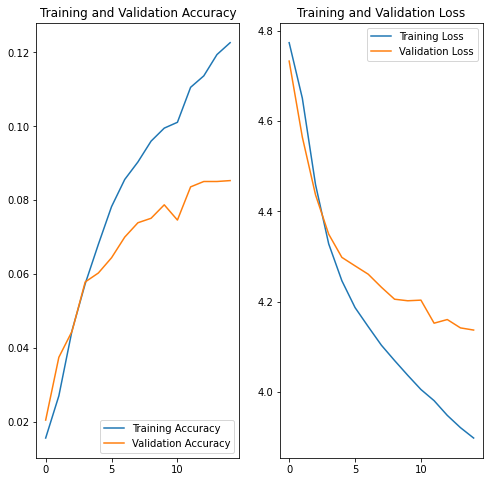

In [19]:
model = Sequential([
  data_augmentation,
  Rescaling(1./255),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.35),
  Flatten(),
  Dense(336, activation='tanh'),
  Dense(len(class_names))
])
model.compile(optimizer=Adam(learning_rate=1.606120839072308e-05),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 33s]
val_accuracy: 0.010895883664488792

Best val_accuracy So Far: 0.013317191042006016
Total elapsed time: 00h 08m 29s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256 and the optimal learning rate for the optimizer
is 0.01.

